In [125]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import warnings
from matplotlib.image import imread
import pandas as pd

In [183]:
INIT_LR = 1e-3
BATCH_SIZE = 16
EPOCHS = 20
IMAGE_SIZE = 224
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "train"
test_dir= "data_for_test"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

# Function to Split Dataset

In [92]:
def get_data_partitions_tf(data, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = data.cardinality().numpy()
    
    if shuffle:
        data = data.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = data.take(train_size)    
    val_ds = data.skip(train_size).take(val_size)
    test_ds = data.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [52]:
# check the files or directories in the training path #
os.listdir(data_dir)

['bed', 'chair', 'sofa', 'swivelchair', 'table']

# Data Exploration

In [53]:
#Select any random directory and view one of the images from the training folder
rand = np.random.randint(len(os.listdir(data_dir)))
furniture_title = os.listdir(data_dir)[rand]

In [54]:
furniture_path = os.path.join(data_dir,furniture_title)
furniture_images  = os.listdir(furniture_path)

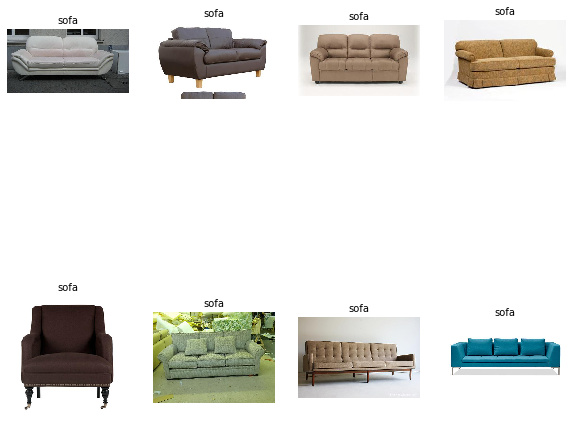

In [55]:
#Displaying Some Images
n_rows = 2
n_cols = 4
plt.figure(figsize=(10, 10))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows,n_cols,index+1)
        sample_image_path = os.path.join(furniture_path + '/',furniture_images[index])
        furniture = imread(sample_image_path)
        plt.imshow(furniture,cmap='binary',interpolation='nearest')
        plt.axis('off')
        plt.title(furniture_title,fontsize=10) 

In [56]:
#check the dimension of each training image
train_ratio = []
train_lx    = []
train_ly    = []

for folder in os.listdir(data_dir):
    for image_filename in os.listdir(data_dir + '/' + folder):
        img = imread(os.path.join(data_dir,folder,image_filename))
        lx,ly = img.shape[0],img.shape[1]
        train_ratio.append(lx/ly)
        train_lx.append(lx)
        train_ly.append(ly)


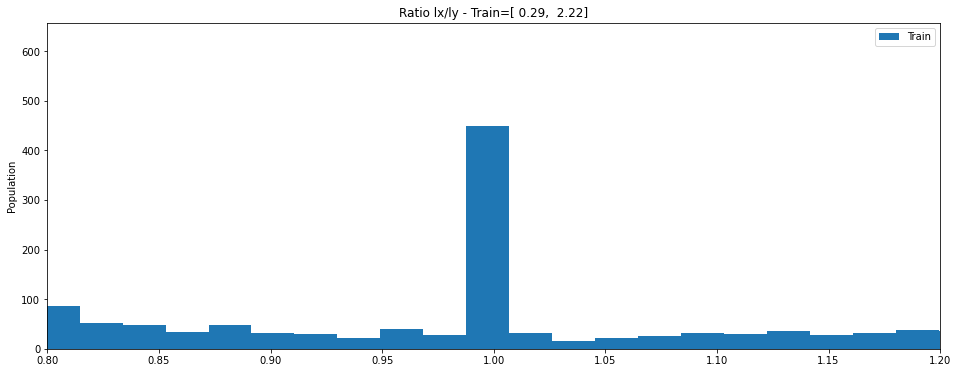

In [57]:
#show the img statistics
plt.figure(figsize=(16,6))
plt.hist([train_ratio], bins=100)
plt.gca().set(title='Ratio lx/ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ratio),max(train_ratio)), 
              ylabel='Population', xlim=[0.8,1.2])
plt.legend(['Train','Test'])
plt.show()

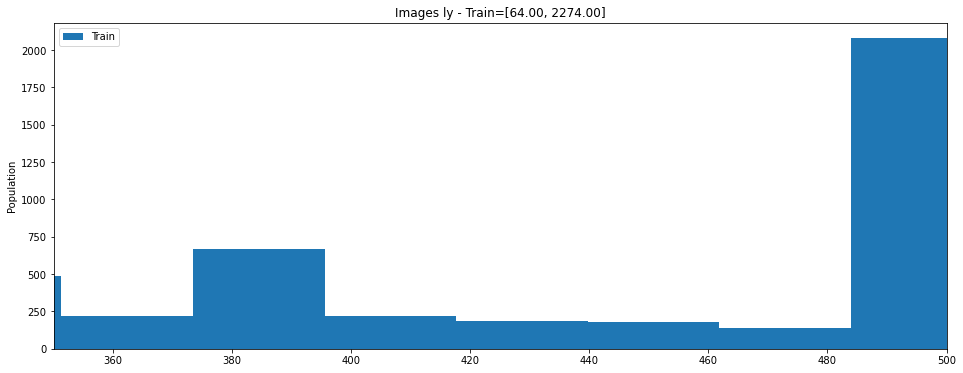

In [58]:
plt.figure(figsize=(16,6))
plt.hist([train_ly], bins=100)
plt.gca().set(title='Images ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ly),max(train_ly)), 
              ylabel='Population', xlim=[350,500])
plt.legend(['Train','Test'])
plt.show()

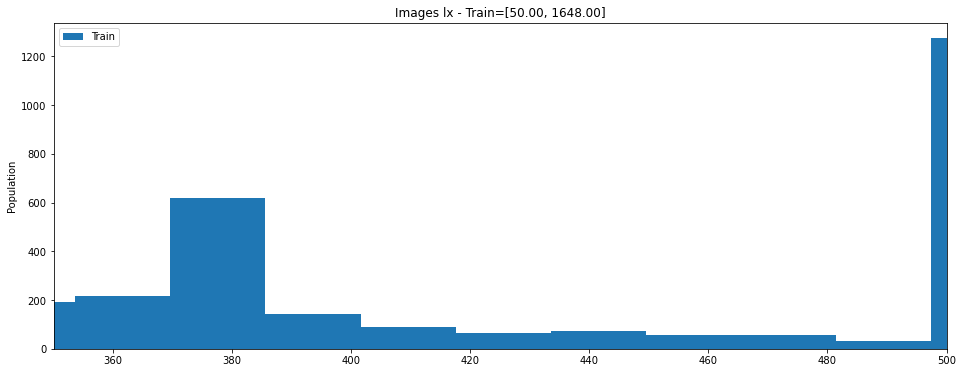

In [59]:
plt.figure(figsize=(16,6))
plt.hist([train_lx], bins=100)
plt.gca().set(title='Images lx - Train=[{:5.2f}, {:5.2f}]'.format(min(train_lx),max(train_lx)), 
              ylabel='Population', xlim=[350,500])
plt.legend(['Train','Test'])
plt.show()

In [60]:
#We can conclude that our dataset consists of images of different dimensions

# Reading and Partitioning the Dataset

We create a Tensorflow Dataset Object and directly read it from the directory using image_dataset_from_directory and then split it using the function we created above

In [93]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  shuffle=True,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_data_partitions_tf(dataset)

Found 6485 files belonging to 5 classes.


In [94]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

5 ['bed', 'chair', 'sofa', 'swivelchair', 'table']


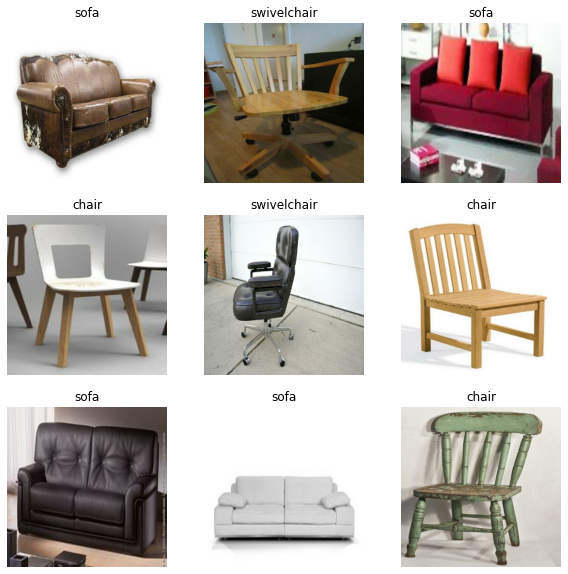

In [63]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [95]:
#checking batch size
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16,)


# Cache, Shuffle, and Prefetch the Dataset

In [96]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Creating a Layer for Resizing and Normalization

Before we feed our images to network, we are going to resize it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [97]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation

In [98]:
# to boost the accuracy of our model
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.1),
])

In [99]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

# Applying Data Augmentation to Train Dataset

In [100]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

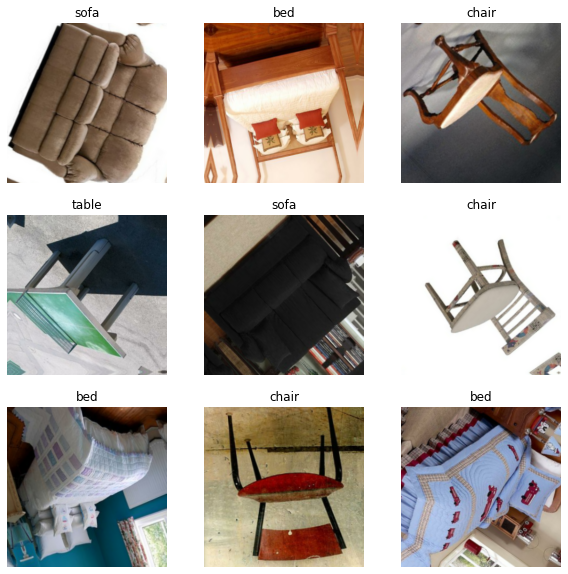

In [70]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Model Architecture

In [71]:
# VGG_c = models.Sequential([
#    resize_and_rescale,
#    #block 1:
#    layers.Conv2D(64, kernel_size = (3,3), activation='relu',padding='same', input_shape=input_shape),
#    layers.Conv2D(64, kernel_size = (3,3), activation='relu',padding='same'),
#    layers.MaxPooling2D((2, 2),strides=(2, 2)),
    #block 2:
#    layers.Conv2D(128, kernel_size = (3,3), activation='relu',padding='same'),
 #   layers.Conv2D(128, kernel_size = (3,3), activation='relu',padding='same'),
#    layers.MaxPooling2D((2, 2),strides=(2, 2)),
    #block 3:
#    layers.Conv2D(256, kernel_size = (3,3), activation='relu',padding='same'),
 #   layers.Conv2D(256, kernel_size = (3,3), activation='relu',padding='same'),
 #   layers.Conv2D(256, kernel_size = (3,3), activation='relu',padding='same'),
  #  layers.MaxPooling2D((2, 2),strides=(2, 2)),
    #BLOCK 4:
   # layers.Conv2D(512, kernel_size = (3,3), activation='relu',padding='same'),
    #layers.Conv2D(512, kernel_size = (3,3), activation='relu',padding='same'),
#    layers.Conv2D(512, kernel_size = (3,3), activation='relu',padding='same'),
#   layers.MaxPooling2D((2, 2),strides=(2, 2)),
#    #block 5:
#    layers.Conv2D(512, kernel_size = (3,3), activation='relu',padding='same'),
#    layers.Conv2D(512, kernel_size = (3,3), activation='relu',padding='same'),
#    layers.Conv2D(512, kernel_size = (3,3), activation='relu',padding='same'),
#    layers.MaxPooling2D((2, 2),strides=(2, 2)),
    # Classification block
#    layers.Flatten(),
#    layers.Dense(4096, activation='relu'),
#    layers.Dense(4096, activation='relu'),
#    layers.Dense(n_classes, activation='softmax'),
#])
#VGG_c.build(input_shape=batch_input_shape)

In [101]:
 model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=batch_input_shape)

In [102]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (16, 224, 224, 3)         0         
                                                                 
 conv2d_91 (Conv2D)          (16, 222, 222, 32)        896       
                                                                 
 max_pooling2d_75 (MaxPoolin  (16, 111, 111, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_92 (Conv2D)          (16, 109, 109, 64)        18496     
                                                                 
 conv2d_93 (Conv2D)          (16, 107, 107, 64)        36928     
                                                                 
 max_pooling2d_76 (MaxPoolin  (16, 53, 53, 64)         0         
 g2D)                                                

Compiling the Model


We used adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [103]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [105]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
324/324 [==============================] - 42s 129ms/step - loss: 1.0840 - accuracy: 0.5737 - val_loss: 1.0207 - val_accuracy: 0.6094
Epoch 2/20
324/324 [==============================] - 44s 134ms/step - loss: 0.9354 - accuracy: 0.6430 - val_loss: 0.8118 - val_accuracy: 0.7125
Epoch 3/20
324/324 [==============================] - 37s 115ms/step - loss: 0.8513 - accuracy: 0.6758 - val_loss: 0.8275 - val_accuracy: 0.6953
Epoch 4/20
324/324 [==============================] - 32s 97ms/step - loss: 0.7994 - accuracy: 0.6988 - val_loss: 0.6935 - val_accuracy: 0.7500
Epoch 5/20
324/324 [==============================] - 31s 97ms/step - loss: 0.7290 - accuracy: 0.7328 - val_loss: 0.6227 - val_accuracy: 0.7688
Epoch 6/20
324/324 [==============================] - 32s 97ms/step - loss: 0.6592 - accuracy: 0.7568 - val_loss: 0.6069 - val_accuracy: 0.7766
Epoch 7/20
324/324 [==============================] - 32s 98ms/step - loss: 0.6529 - accuracy: 0.7587 - val_loss: 0.6518 - val_accura

In [106]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
42/42 [==============================] - 3s 22ms/step - loss: 0.4026 - accuracy: 0.8438
Test Accuracy: 84.38%


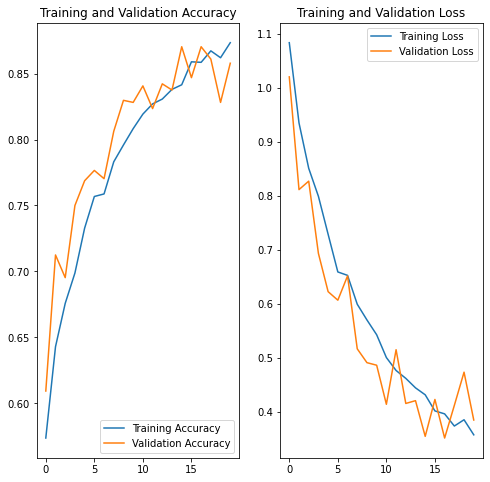

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [110]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


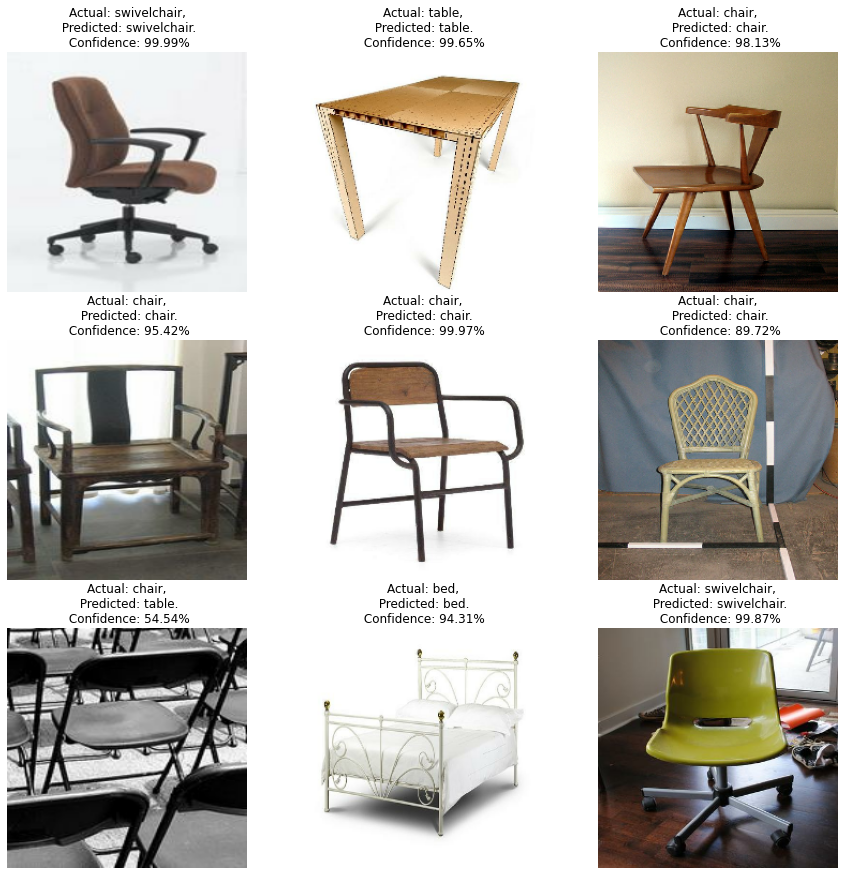

In [115]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [116]:
model.save("../classif.h5")

In [184]:
testset = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  shuffle=False,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)

Found 2164 files belonging to 1 classes.


1/1 [==============================] - 0s 18ms/step


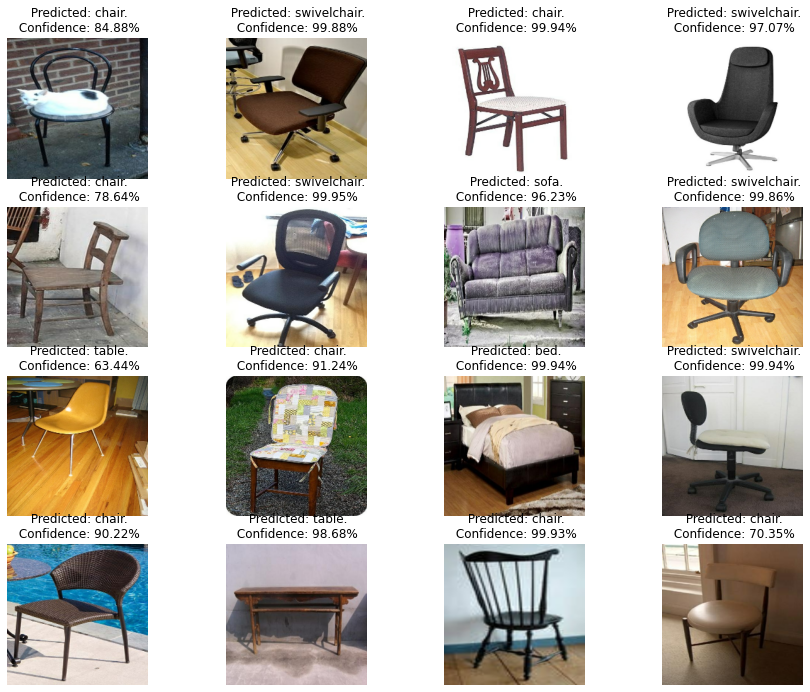

In [247]:
plt.figure(figsize=(15, 15))
for images, labels in testset.take(1):
    for i in range(16):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy()) 
        
        plt.title(f" Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")